In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

Function for data frame manipulations that are same for all data frames.

In [229]:
def df_maniplualtion(path):
    data_frame = pd.read_csv(path)
    data_frame = data_frame.rename(columns={"Name": "Date"})
    data_frame["Date"] = pd.to_datetime(data_frame["Date"], format="%d/%m/%Y")
    data_frame['Date'] = data_frame['Date'].dt.strftime('%Y-%m')
    data_frame.set_index('Date', inplace=True)
    return data_frame

Dependant variable data frame

In [230]:
dependentVariable = df_maniplualtion('data/depVariable.csv')
dependentVariable

,JAPAN-DS Market - TOT RETURN IND,JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ
Date,,
1989-12,1007.32,6.4480
1990-01,958.47,6.5810
1990-02,894.37,6.6430
1990-03,779.75,6.8170
1990-04,777.05,7.1630
...,...,...
2020-05,980.89,-0.0015
2020-06,980.94,-0.0015
2020-07,946.83,-0.0015


Monthly data

In [231]:
monthlyIndex = df_maniplualtion('data/Monthly.csv')
monthlyIndex

,JAPAN-DS Market - DIVIDEND YIELD,JAPAN-DS Market - PRICE INDEX,JAPAN-DS Market - TOT RETURN IND,JAPAN-DS Market - PER,JAPAN-DS Market - PRICE/BOOK RATIO,JAPAN-DS Market - PE RATIO 12M FWD,JAPAN-DS Market - MARKET VALUE,JAPAN-DS Market - ROE,JAPAN-DS Market - TOTAL ASSETS,JAPAN-DS Market - NET DEBT,...,NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX,JP ISSUES: CORPORATE STRAIGHT BONDS CURN,JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN,JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ,JP CPI: NATIONAL MEASURE - ANNUAL INFLATION RATE NADJ,"JP MONEY SUPPLY: M2 (METHO-BREAK, APR. 2003) CURA",JP JAPANESE YEN TO US $ NADJ,JP PETROLEUM: CONSUMPTION VOLN,JP UNEMPLOYMENT RATE (METHO BREAK OCT 2010) SADJ,JP INDUSTRIAL PRODUCTION - MINING & MANUFACTURING VOLA
Date,,,,,,,,,,,,,,,,,,,,,
1989-12,0.43,768.21,1007.32,60.6,4.05,40.88,535950600,8.35,3.378970e+11,6.317994e+10,...,20.32,15000,13236.45,6.4480,2.64,455632.2,143.7079,6252.45,2.1,104.4
1990-01,0.45,730.66,958.47,57.4,3.82,40.78,513422800,8.23,3.407350e+11,6.325462e+10,...,17.56,0,3668.14,6.5810,3.34,461555.6,144.9468,5702.94,2.2,103.5
1990-02,0.49,681.56,894.37,53.3,3.59,38.91,479338500,8.22,3.410670e+11,6.319519e+10,...,15.92,144000,4862.99,6.6430,3.82,469357.7,145.6150,6045.61,2.2,104.4
1990-03,0.56,593.94,779.75,46.5,3.10,35.38,418150400,8.23,3.411190e+11,6.319455e+10,...,28.07,120000,7573.41,6.8170,3.56,471653.1,153.1964,5666.58,2.0,106.4
1990-04,0.56,591.61,777.05,46.4,2.98,30.98,420146400,7.91,3.998830e+11,6.928813e+10,...,55.05,310000,1176.16,7.1630,2.71,479005.5,158.3026,4826.67,2.1,106.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05,2.47,496.02,980.89,16.8,1.22,14.54,588487400,6.42,2.969930e+12,5.128516e+09,...,27.60,681000,0.00,-0.0015,0.00,1077196.9,107.2668,2728.10,2.9,78.7
2020-06,2.48,495.02,980.94,16.9,1.23,16.85,586178800,5.06,3.028680e+12,-1.295236e+10,...,29.12,1910700,58.64,-0.0015,0.10,1099866.6,107.6050,2860.43,2.8,80.2
2020-07,2.54,476.77,946.83,17.1,1.19,17.35,567044900,5.05,3.028840e+12,-1.288441e+10,...,25.96,2543300,567.57,-0.0015,0.30,1108556.4,106.7357,2981.48,2.9,87.2


Change variable

In [232]:
changeVariables = df_maniplualtion('data/changeVariable.csv')
changeVariables

,JAPAN-DS Market - DIVIDEND YIELD,JAPAN-DS Market - PRICE INDEX,JAPAN-DS Market - TOT RETURN IND,JAPAN-DS Market - MARKET VALUE,US REFINERS ACQUISITION COST OF DOM. & IMPORTED CRUDE OIL CURN,WD CRUDE OIL PRODUCTION - WORLD VOLN,JP INDUSTRIAL PRODUCTION - MINING & MANUFACTURING VOLA,NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX,JP UNEMPLOYMENT RATE (METHO BREAK OCT 2010) SADJ,"JP MONEY SUPPLY: M2 (METHO-BREAK, APR. 2003) CURA",JP PETROLEUM: CONSUMPTION VOLN
Date,,,,,,,,,,,
1989-11,0.44,755.76,990.66,525260000,18.39,53478.675,104.0,8.68,2.2,449496.1,5396.87
1989-12,0.43,768.21,1007.32,535950600,19.54,53091.781,104.4,20.32,2.1,455632.2,6252.45
1990-01,0.45,730.66,958.47,513422800,20.64,52775.965,103.5,17.56,2.2,461555.6,5702.94
1990-02,0.49,681.56,894.37,479338500,20.31,52968.492,104.4,15.92,2.2,469357.7,6045.61
1990-03,0.56,593.94,779.75,418150400,19.14,53715.599,106.4,28.07,2.0,471653.1,5666.58
...,...,...,...,...,...,...,...,...,...,...,...
2020-05,2.47,496.02,980.89,588487400,23.84,71450.412,78.7,27.60,2.9,1077196.9,2728.10
2020-06,2.48,495.02,980.94,586178800,36.80,70323.206,80.2,29.12,2.8,1099866.6,2860.43
2020-07,2.54,476.77,946.83,567044900,40.07,71584.837,87.2,25.96,2.9,1108556.4,2981.48


Smoothed 10 years earnings to price ratio

In [233]:
smoothedEP = df_maniplualtion('data/smoothedPE.csv')
smoothedEP

,JAPAN-DS Market - PER,JAPAN-DS Market - PRICE INDEX,JAPAN-DS Market - TOT RETURN IND,JAPAN-DS Market - DIVIDEND YIELD
Date,,,,
1979-12,20.2,118.31,138.41,1.89
1980-01,20.5,120.37,141.06,1.85
1980-02,20.4,120.00,140.83,1.82
1980-03,19.6,116.55,136.99,1.90
1980-04,19.9,120.00,141.28,1.86
...,...,...,...,...
2020-05,16.8,496.02,980.89,2.47
2020-06,16.9,495.02,980.94,2.48
2020-07,17.1,476.77,946.83,2.54


Variance data frame, I don't use df_manipulation function because we need day information.

In [234]:
stockVariance = pd.read_csv('data/stockVar.csv')
stockVariance = stockVariance.rename(columns={"Name": "Date"})
stockVariance["Date"] = pd.to_datetime(stockVariance["Date"], format="%d/%m/%Y")
stockVariance.set_index('Date', inplace=True)

stockVariance = stockVariance.rename(columns={"JAPAN-DS Market - PRICE INDEX": "var"})
stockVariance

,var
Date,
1989-11-30,755.76
1989-12-01,752.46
1989-12-04,756.28
1989-12-05,759.63
1989-12-06,764.02
...,...
2020-09-24,515.01
2020-09-25,517.64
2020-09-28,525.94


Net equity expansion

In [235]:
netIssue = df_maniplualtion('data/netEquExp.csv')
netIssue

,JAPAN-DS Market - MARKET VALUE,JAPAN-DS Market - PRICE INDEX
Date,,
1988-10,388626200,585.76
1988-11,416910600,626.23
1988-12,431281700,645.93
1989-01,452533200,673.61
1989-02,448808700,665.72
...,...,...
2020-05,588487400,496.02
2020-06,586178800,495.02
2020-07,582071600,489.43


In [236]:
notCompVwretd = pd.DataFrame(dependentVariable["JAPAN-DS Market - TOT RETURN IND"].pct_change(1) - ((dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]/100)/12))
notCompVwretd

,0
Date,
1989-12,NaN
1990-01,-0.053979
1990-02,-0.072413
1990-03,-0.133838
1990-04,-0.009432
...,...
2020-05,0.071111
2020-06,0.000052
2020-07,-0.034772


Excess market return following Li et al (2013) for regression: log(1+ret%) - log (1+tbill%)

In [237]:
dependentVariable["JAPAN-DS Market - TOT RETURN IND"] = np.log(dependentVariable["JAPAN-DS Market - TOT RETURN IND"]/dependentVariable["JAPAN-DS Market - TOT RETURN IND"].shift(1))

dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"] = np.log(1+(dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]/100)/12)

dependentVariable["JAPAN-DS Market - TOT RETURN IND"] -= dependentVariable["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"]

dependentVariable = dependentVariable.drop(columns=["JP OVERNIGHT UNCOLLATERISED CALL MONEY RATE (AVG.) NADJ"])
dependentVariable = dependentVariable.rename(columns={"JAPAN-DS Market - TOT RETURN IND": "totalReturnChange"})
dependentVariable = dependentVariable.dropna()
dependentVariable

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,totalReturnChange
Date,
1990-01,-0.055180
1990-02,-0.074739
1990-03,-0.142811
1990-04,-0.009420
1990-05,0.087576
...,...
2020-05,0.068696
2020-06,0.000052
2020-07,-0.035390


Help variables for valuation ratios

In [238]:
dividends = monthlyIndex["JAPAN-DS Market - PRICE INDEX"]/monthlyIndex["JAPAN-DS Market - TOT RETURN IND"]
price = dividends/monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]*100
earnings = price/monthlyIndex["JAPAN-DS Market - PER"]
dividendPriceRatio = pd.DataFrame(monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]/100)
dividendPriceRatio = dividendPriceRatio.rename(columns={dividendPriceRatio.columns[0]: "D/P"})
bookToMarketRatio = 1/pd.DataFrame(monthlyIndex["JAPAN-DS Market - PRICE/BOOK RATIO"])
bookToMarketRatio = bookToMarketRatio.rename(columns={"JAPAN-DS Market - PRICE/BOOK RATIO": "B/M"})

earningsToPriceRatio = 1/pd.DataFrame(monthlyIndex["JAPAN-DS Market - PER"])
earningsToPriceRatio = earningsToPriceRatio.rename(columns={"JAPAN-DS Market - PER": "E/P"})

Volatility and variance variables

In [239]:
volatilityIndex = pd.DataFrame(np.log(1 + changeVariables["NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX"].diff() / changeVariables["NIKKEI STOCK AVERAGE VOLATILITY INDEX - PRICE INDEX"].shift(1)))

volatilityIndex = volatilityIndex.dropna()
volatilityIndex = volatilityIndex.rename(columns={volatilityIndex.columns[0]: "Vola"})

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [240]:
stockVariance = pd.DataFrame((stockVariance["var"].diff() / stockVariance["var"].shift(1)).dropna())
stockVariance

,var
Date,
1989-12-01,-0.004366
1989-12-04,0.005077
1989-12-05,0.004430
1989-12-06,0.005779
1989-12-07,0.005091
...,...
2020-09-24,-0.010433
2020-09-25,0.005107
2020-09-28,0.016034


Here my results differ a bit from Conway's results. Maybe we can discuss this next time we meet.

In [241]:
stockVariance = stockVariance.rolling(8044, min_periods=2).var()
stockVariance = stockVariance.loc[stockVariance.groupby(stockVariance.index.to_period('M')).apply(lambda x: x.index.max())]
stockVariance.index = stockVariance.index.strftime('%Y-%m')
stockVariance

,var
Date,
1989-12,0.000042
1990-01,0.000051
1990-02,0.000103
1990-03,0.000172
1990-04,0.000234
...,...
2020-05,0.000161
2020-06,0.000161
2020-07,0.000161


In [242]:
sDividends = smoothedEP["JAPAN-DS Market - PRICE INDEX"]/smoothedEP["JAPAN-DS Market - TOT RETURN IND"]
sPrice = sDividends/smoothedEP["JAPAN-DS Market - DIVIDEND YIELD"]*100
sEarnings = sPrice/smoothedEP["JAPAN-DS Market - PER"]
sEarnings = sEarnings.rolling(119).mean()
smoothedEP = sEarnings.dropna()

# Dates for December 1989 don't match in price and smoothedEP, so I change them manually.
price1 = price.copy()
price1.index.array[0] = '1989-12-29'

smoothedEP = (1/price1/smoothedEP).dropna()

# Small difference again, but not big
smoothedEP = pd.DataFrame(smoothedEP)
smoothedEP = smoothedEP.rename(columns={smoothedEP.columns[0]: "E10/P"})
smoothedEP

,E10/P
Date,
1990-01,0.002476
1990-02,0.002691
1990-03,0.003070
1990-04,0.003065
1990-05,0.002846
...,...
2020-05,0.026802
2020-06,0.027017
2020-07,0.027828


In [243]:
percentEquityIssuing = pd.DataFrame(monthlyIndex["JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN"]/(monthlyIndex["JP ISSUES: CORPORATE STRAIGHT BONDS CURN"] + monthlyIndex["JP STOCKS: PUBLIC OFFERINGS - AMOUNT RAISED CURN"]))
percentEquityIssuing = pd.DataFrame(percentEquityIssuing.fillna(0))
percentEquityIssuing = percentEquityIssuing.rename(columns={percentEquityIssuing.columns[0]: "Equis"})

inflationRate = pd.DataFrame(monthlyIndex["JP CPI: NATIONAL MEASURE - ANNUAL INFLATION RATE NADJ"]/100)
inflationRate = inflationRate.rename(columns={inflationRate.columns[0]: "Ifl"})
inflationRate

,Ifl
Date,
1989-12-29,0.0264
1990-01,0.0334
1990-02,0.0382
1990-03,0.0356
1990-04,0.0271
...,...
2020-05,0.0000
2020-06,0.0010
2020-07,0.0030


In [244]:
def change(x, column):
    return pd.DataFrame((x[column].diff() / x[column].shift(1)).dropna())

In [245]:
realMoneySupply = change(changeVariables, "JP MONEY SUPPLY: M2 (METHO-BREAK, APR. 2003) CURA")
realMoneySupply = realMoneySupply.rename(columns={realMoneySupply.columns[0]: "Rms"})

petroleumConsumption = change(changeVariables, "JP PETROLEUM: CONSUMPTION VOLN")
petroleumConsumption = petroleumConsumption.rename(columns={petroleumConsumption.columns[0]: "PCon"})
unemploymentRate = change(changeVariables, "JP UNEMPLOYMENT RATE (METHO BREAK OCT 2010) SADJ")
unemploymentRate = unemploymentRate.rename(columns={unemploymentRate.columns[0]: "Unem"})
industrialProduction = change(changeVariables, "JP INDUSTRIAL PRODUCTION - MINING & MANUFACTURING VOLA")
industrialProduction = industrialProduction.rename(columns={industrialProduction.columns[0]: "IProd"})
crudeOilPriceChange = change(changeVariables, "US REFINERS ACQUISITION COST OF DOM. & IMPORTED CRUDE OIL CURN")
crudeOilPriceChange = crudeOilPriceChange.rename(columns={crudeOilPriceChange.columns[0]: "C/P"})
crudeOilProduction = change(changeVariables, "WD CRUDE OIL PRODUCTION - WORLD VOLN")
crudeOilProduction = crudeOilProduction.rename(columns={crudeOilProduction.columns[0]: "C/O"})

petroleumConsumption

,PCon
Date,
1989-12,0.158533
1990-01,-0.087887
1990-02,0.060087
1990-03,-0.062695
1990-04,-0.148222
...,...
2020-05,-0.113784
2020-06,0.048506
2020-07,0.042319


In [246]:
mv = netIssue["JAPAN-DS Market - MARKET VALUE"]

temp9 = netIssue["JAPAN-DS Market - PRICE INDEX"].diff() / netIssue["JAPAN-DS Market - PRICE INDEX"].shift(1)
netIssue = netIssue["JAPAN-DS Market - MARKET VALUE"] - netIssue["JAPAN-DS Market - MARKET VALUE"].shift(1)*(1+temp9)

#Slight differences again, could be because of rolling functions
netIssue = (netIssue.rolling(window=12, min_periods=3).sum()).dropna()
netIssue = (netIssue/mv).dropna()
netIssue = pd.DataFrame(netIssue)
netIssue = netIssue.rename(columns={netIssue.columns[0]: "Ntis"})

netIssue

,Ntis
Date,
1989-01,0.012065
1989-02,0.015677
1989-03,0.018582
1989-04,0.022132
1989-05,0.024454
...,...
2020-05,-0.008399
2020-06,-0.010856
2020-07,-0.006121


In [247]:
netPY = (monthlyIndex["JAPAN-DS Market - DIVIDEND YIELD"]/100) + (((changeVariables["JAPAN-DS Market - MARKET VALUE"].shift(1) * (changeVariables["JAPAN-DS Market - PRICE INDEX"]/changeVariables["JAPAN-DS Market - PRICE INDEX"].shift(1))) - changeVariables["JAPAN-DS Market - MARKET VALUE"])/changeVariables["JAPAN-DS Market - MARKET VALUE"])
netPY = pd.DataFrame((np.log(0.1 + netPY)).dropna())
netPY = netPY.rename(columns={netPY.columns[0]: "Ndy"})

netPY

/Users/jessekeranen/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Ndy
Date,
1990-01,-2.329411
1990-02,-2.263085
1990-03,-2.257990
1990-04,-2.333612
1990-05,-2.258949
...,...
2020-05,-2.065549
2020-06,-2.065820
2020-07,-2.111701


In [248]:
def rollingmean(length):
    temp = dependentVariable.rolling(length).mean().shift(-length)
    #temp["totalReturnChange"] = temp["totalReturnChange"].shift(1)
    temp = temp.rename(columns={temp.columns[0]: ("K" + str(length))})
    return pd.DataFrame(temp)

In [249]:
mk12 = rollingmean(12)
mk24 = rollingmean(24)
mk36 = rollingmean(36)
mk48 = rollingmean(48)

mk48

,K48
Date,
1990-01,-0.013811
1990-02,-0.012198
1990-03,-0.010192
1990-04,-0.009574
1990-05,-0.010493
...,...
2020-05,NaN
2020-06,NaN
2020-07,NaN


Fama and French factors

In [250]:
famafrench = pd.read_csv("data/Japan_5_Factors.csv")
famafrench["Date"] = pd.to_datetime(famafrench["Date"], format="%Y%m")
famafrench['Date'] = famafrench['Date'].dt.strftime('%Y-%m')
famafrench.set_index('Date', inplace=True)
famafrench = famafrench.loc[:].div(100)
famafrench = famafrench.drop(columns={"RF"})

mom = pd.read_csv("data/Japan_MOM_Factor.csv")
mom['Date'] = pd.to_datetime(mom["Date"], format="%Y%m")
mom['Date'] = mom['Date'].dt.strftime('%Y-%m')
mom.set_index('Date', inplace=True)
mom = mom.loc[:].div(100)

famafrench

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1990-07,0.0010,0.0627,0.0363,0.0060,0.0024
1990-08,-0.1188,-0.0497,0.0033,0.0171,-0.0096
1990-09,-0.1738,0.0064,0.0014,-0.0112,-0.0011
1990-10,0.2490,0.0071,-0.0455,-0.0012,0.0475
1990-11,-0.1412,-0.0520,-0.0020,0.0386,-0.0218
...,...,...,...,...,...
2022-06,-0.0682,0.0164,0.0319,-0.0200,0.0161
2022-07,0.0567,0.0063,-0.0557,0.0327,-0.0244
2022-08,-0.0311,0.0132,0.0083,-0.0099,0.0061


In [251]:
finalmonthlyOnlyIV = dividendPriceRatio.merge(bookToMarketRatio, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(earningsToPriceRatio, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(smoothedEP, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(percentEquityIssuing, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(netIssue, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(netPY, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(inflationRate, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(realMoneySupply, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(crudeOilPriceChange, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(crudeOilProduction, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(petroleumConsumption, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(industrialProduction, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(unemploymentRate, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(stockVariance, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(volatilityIndex, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(famafrench, on="Date")
finalmonthlyOnlyIV = finalmonthlyOnlyIV.merge(mom, on="Date")

In [252]:
finalmonthlyOnlyIV

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,IProd,Unem,var,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML
Date,,,,,,,,,,,,,,,,,,,,,
1990-11,0.0076,0.452489,0.027174,0.004159,0.000000,0.048690,-2.229692,0.0392,-0.003211,-0.079059,...,-0.007233,-0.090909,0.000276,-0.306572,-0.1412,-0.0520,-0.0020,0.0386,-0.0218,0.0150
1990-12,0.0072,0.431034,0.025907,0.003940,0.000000,0.042562,-2.259815,0.0370,0.002183,-0.145151,...,0.000000,0.000000,0.000275,-0.162792,0.0193,-0.0611,-0.0361,0.0123,0.0187,-0.0804
1991-01,0.0073,0.442478,0.026110,0.003995,0.001765,0.036230,-2.251344,0.0390,0.002065,-0.124186,...,0.009107,0.000000,0.000268,-0.115269,0.0119,-0.0773,0.0024,0.0218,0.0068,0.0046
1991-02,0.0064,0.380228,0.022989,0.003502,0.000754,0.029557,-2.243554,0.0356,0.000141,-0.167177,...,0.001805,0.050000,0.000264,-0.212098,0.1229,0.1132,0.0080,-0.0569,0.0074,-0.1523
1991-03,0.0064,0.381679,0.022831,0.003501,0.002583,0.028193,-2.240495,0.0366,0.000227,-0.059905,...,-0.010811,0.047619,0.000253,0.169855,-0.0421,0.0380,0.0040,0.0167,-0.0126,0.0145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05,0.0247,0.819672,0.059524,0.026802,0.000000,-0.008399,-2.065549,0.0000,0.016958,0.228233,...,-0.089120,0.115385,0.000161,-0.128674,0.0643,0.0287,-0.0739,0.0214,-0.0279,-0.0259
2020-06,0.0248,0.813008,0.059172,0.027017,0.000031,-0.010856,-2.065820,0.0010,0.021045,0.543624,...,0.019060,-0.034483,0.000161,0.053609,-0.0022,0.0033,-0.0397,0.0217,-0.0254,0.0463
2020-07,0.0254,0.840336,0.058480,0.027828,0.000223,-0.006121,-2.111701,0.0030,0.007901,0.088859,...,0.087282,0.035714,0.000161,-0.114868,-0.0198,-0.0177,-0.0276,0.0077,-0.0257,0.0679


In [253]:
dependentVariable["totalReturnChange"] = dependentVariable["totalReturnChange"].shift(-1)
dependentVariable = dependentVariable.dropna()
dependentVariable = dependentVariable.rename(columns={dependentVariable.columns[0]: "K1"})
finalIndexMonthly = finalmonthlyOnlyIV.merge(dependentVariable, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk12, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk24, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk36, on='Date')
finalIndexMonthly = finalIndexMonthly.merge(mk48, on='Date')

In [254]:
finalIndexMonthly

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,SMB,HML,RMW,CMA,WML,K1,K12,K24,K36,K48
Date,,,,,,,,,,,,,,,,,,,,,
1990-11,0.0076,0.452489,0.027174,0.004159,0.000000,0.048690,-2.229692,0.0392,-0.003211,-0.079059,...,-0.0520,-0.0020,0.0386,-0.0218,0.0150,0.044476,-0.001711,-0.013373,-0.007927,-0.004166
1990-12,0.0072,0.431034,0.025907,0.003940,0.000000,0.042562,-2.259815,0.0370,0.002183,-0.145151,...,-0.0611,-0.0361,0.0123,0.0187,-0.0804,-0.014174,-0.006724,-0.015631,-0.007854,-0.004589
1991-01,0.0073,0.442478,0.026110,0.003995,0.001765,0.036230,-2.251344,0.0390,0.002065,-0.124186,...,-0.0773,0.0024,0.0218,0.0068,0.0046,0.121963,-0.009776,-0.015301,-0.004005,-0.005820
1991-02,0.0064,0.380228,0.022989,0.003502,0.000754,0.029557,-2.243554,0.0356,0.000141,-0.167177,...,0.1132,0.0080,-0.0569,0.0074,-0.1523,0.001511,-0.023902,-0.020829,-0.007318,-0.010064
1991-03,0.0064,0.381679,0.022831,0.003501,0.002583,0.028193,-2.240495,0.0366,0.000227,-0.059905,...,0.0380,0.0040,0.0167,-0.0126,0.0145,-0.009280,-0.032089,-0.016152,-0.008653,-0.010574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,0.0267,0.877193,0.069930,0.028855,0.000047,-0.007739,-2.061946,0.0010,0.007481,-0.403687,...,0.0220,-0.0700,0.0359,-0.0612,0.0109,0.068696,NaN,NaN,NaN,NaN
2020-05,0.0247,0.819672,0.059524,0.026802,0.000000,-0.008399,-2.065549,0.0000,0.016958,0.228233,...,0.0287,-0.0739,0.0214,-0.0279,-0.0259,0.000052,NaN,NaN,NaN,NaN
2020-06,0.0248,0.813008,0.059172,0.027017,0.000031,-0.010856,-2.065820,0.0010,0.021045,0.543624,...,0.0033,-0.0397,0.0217,-0.0254,0.0463,-0.035390,NaN,NaN,NaN,NaN


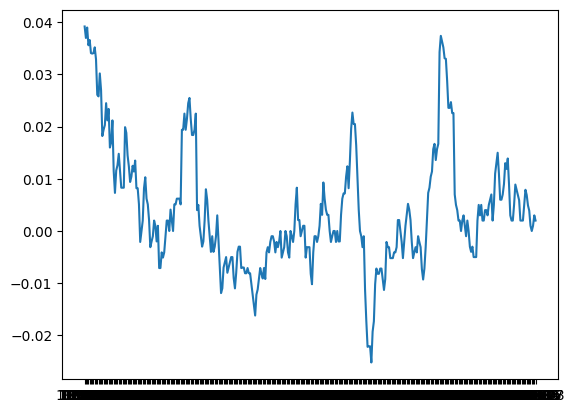

In [255]:
plt.plot(finalIndexMonthly.index, finalIndexMonthly["Ifl"])

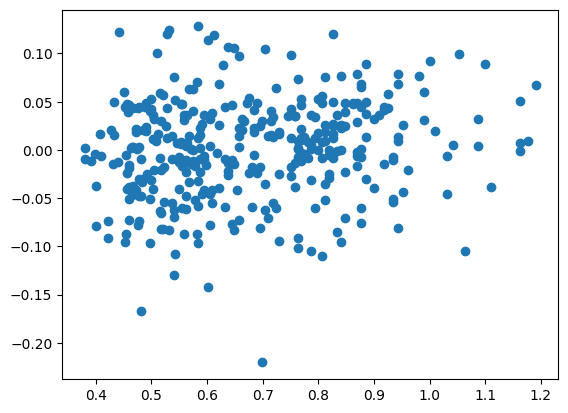

In [256]:
plt.scatter(finalIndexMonthly["B/M"], finalIndexMonthly["K1"])

In [257]:
test = finalIndexMonthly.iloc[:, :-5]
features = list(test.columns)
features.insert(0, "const")
X = test.values.tolist()
X = sm.add_constant(X)
y = finalIndexMonthly["K1"].tolist()

correlations = test.corr()

correlations

,D/P,B/M,E/P,E10/P,Equis,Ntis,Ndy,Ifl,Rms,C/P,...,IProd,Unem,var,Vola,Mkt-RF,SMB,HML,RMW,CMA,WML
D/P,1.000000,0.878758,0.924519,0.979612,0.067487,-0.558504,0.783946,-0.086736,0.205332,-0.057296,...,-0.114210,-0.015883,0.035618,0.019099,-0.003537,0.065888,-0.122661,0.011107,0.005273,-0.022406
B/M,0.878758,1.000000,0.815564,0.847941,0.131694,-0.366091,0.674199,-0.248634,0.139240,-0.043093,...,-0.067285,-0.047278,0.005867,0.010810,-0.010951,0.092501,-0.083446,0.019606,0.014239,-0.019647
E/P,0.924519,0.815564,1.000000,0.940962,0.033585,-0.514956,0.732764,0.061185,0.138903,-0.081748,...,-0.105846,-0.082556,0.066690,0.020027,-0.009158,0.052297,-0.104800,-0.001850,0.029463,-0.010749
E10/P,0.979612,0.847941,0.940962,1.000000,0.053215,-0.547231,0.767440,-0.102041,0.241165,-0.039489,...,-0.089741,-0.035999,-0.016168,0.016073,0.017824,0.071196,-0.131953,0.019956,-0.016541,-0.015903
Equis,0.067487,0.131694,0.033585,0.053215,1.000000,0.112218,0.027380,-0.188877,-0.043094,0.056444,...,0.095890,-0.084884,-0.008654,0.008344,-0.005824,0.036115,0.138064,0.021313,-0.023229,0.016883
Ntis,-0.558504,-0.366091,-0.514956,-0.547231,0.112218,1.000000,-0.523944,-0.118097,-0.154884,0.039284,...,0.063920,-0.046381,0.039717,-0.030149,-0.091525,0.003445,0.087926,0.060130,-0.037908,0.005917
Ndy,0.783946,0.674199,0.732764,0.767440,0.027380,-0.523944,1.000000,-0.036258,0.147318,-0.026942,...,-0.104374,-0.033731,0.037305,0.110479,-0.055950,0.045000,-0.101460,0.036788,-0.047469,0.003978
Ifl,-0.086736,-0.248634,0.061185,-0.102041,-0.188877,-0.118097,-0.036258,1.000000,-0.091868,-0.226461,...,-0.110901,-0.008730,0.476935,0.014938,-0.079899,-0.084735,-0.008885,-0.003424,0.098427,0.005872
Rms,0.205332,0.139240,0.138903,0.241165,-0.043094,-0.154884,0.147318,-0.091868,1.000000,0.153182,...,-0.045353,0.094643,-0.127594,-0.071828,0.057002,0.032546,-0.168408,0.026664,-0.114512,-0.006446
C/P,-0.057296,-0.043093,-0.081748,-0.039489,0.056444,0.039284,-0.026942,-0.226461,0.153182,1.000000,...,0.184944,-0.120190,-0.133068,-0.049910,0.158908,0.056661,-0.002207,-0.011851,-0.101950,-0.050247


In [258]:
ols = sm.OLS(y, X).fit()

print(ols.summary(xname=features))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.615
Date:                Thu, 15 Dec 2022   Prob (F-statistic):             0.0409
Time:                        20:30:08   Log-Likelihood:                 570.01
No. Observations:                 358   AIC:                            -1094.
Df Residuals:                     335   BIC:                            -1005.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1249      0.138      0.907      0.3

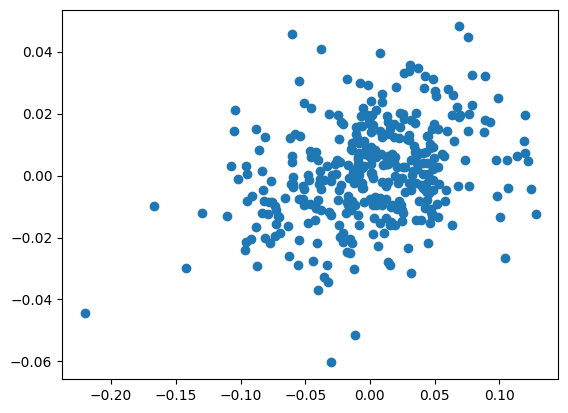

In [259]:
pred = ols.predict(X)
plt.scatter(y, pred)

Out of sample predictions

In [260]:
dates = finalIndexMonthly.loc["2002-01":].index
results = []
predictions = []

for date in dates:
    out_of_sample = finalmonthlyOnlyIV.loc[date]
    df = finalIndexMonthly.loc[:date].iloc[:-1, :-4]
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1:]
    ols = sm.OLS(y, X).fit()
    results.append(ols)
    prediction = [date, ols.predict(out_of_sample)[0]]
    predictions.append(prediction)

pred_df = pd.DataFrame(predictions)
pred_df = pred_df.rename(columns={0: "Date", 1: "Pred"})
pred_df.set_index('Date', inplace=True)
pred_df

,Pred
Date,
2002-01,0.015090
2002-02,0.020116
2002-03,0.012254
2002-04,0.000218
2002-05,0.033091
...,...
2020-04,0.001692
2020-05,-0.018219
2020-06,-0.043986


In [261]:
df2 = pred_df.merge(finalIndexMonthly["K1"], on="Date")
df2

,Pred,K1
Date,,
2002-01,0.015090,0.040751
2002-02,0.020116,0.048307
2002-03,0.012254,0.020142
2002-04,0.000218,0.035865
2002-05,0.033091,-0.087744
...,...,...
2020-04,0.001692,0.068696
2020-05,-0.018219,0.000052
2020-06,-0.043986,-0.035390


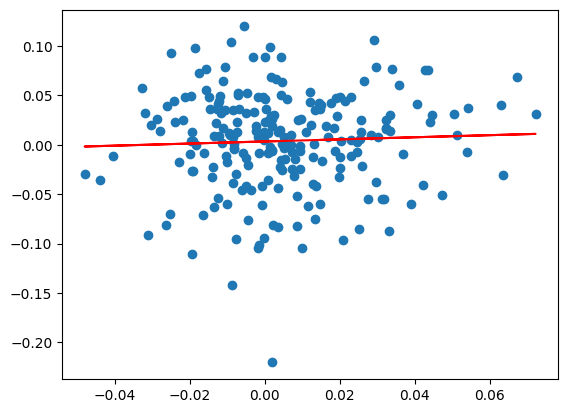

In [262]:
X = sm.add_constant(df2["Pred"])
y = df2["K1"]
reg = sm.OLS(y, X).fit()

coef, intrcpt = np.polyfit(df2["Pred"], y, 1)
plt.scatter(df2["Pred"], df2["K1"])
plt.plot(df2["Pred"], coef*df2["Pred"] + intrcpt, color="red")

In [265]:
np.corrcoef(df2["Pred"], df2["K1"])

array([[1.        , 0.04521209],
       [0.04521209, 1.        ]])